<h1  style="color:white; background-color: #154360; padding:30px;"> 
Résultats numériques de l'algorithme Longstaff-Schwartz avec MLP  </h1>

In [1]:
import sys
import helper_plots


sys.path.append("..")


import numpy as np

import src.tools.diffusion.black_scholes as bs

import src.tools.basis_function.basis_function as basis_function

import src.tools.option.option_main_class as option_main_class

import torch
from typing import List
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import src.main.dynamic_programming.nn_ls_pricer as nn_ls_pricer

In [29]:
d = 50
spot = 100
strike = 100
vol = 0.2
rate = 0.05
dividend = 0.10
T = 3

weights = [20+d, 20+d]
batch_size = 10000
learning_rate = 1e-2
epochs = 30
activation_function = torch.nn.ReLU()

def call_payoff(x):
    d = x.shape[1]
    max_mat = np.zeros((x.shape[0], d))
    for i in range(d):
        max_mat[:, i] = np.maximum(x[:, i] - strike, 0)
    return np.max(max_mat, axis=1)

In [30]:
asset = [bs.BlackScholes(spot, rate, vol,dividend) for i in range(d)]
option_ = option_main_class.Option(T, strike, rate, call_payoff)

pricer_ltls = nn_ls_pricer.PricerNNLongstaffSchwarz(
    option_, asset, weights, learning_rate, batch_size, activation_function, epochs
)

In [31]:
n, N = 10, 100000
price, ci, cd, _, _ = pricer_ltls.price(n, N, disable=False)

100%|██████████| 8/8 [01:30<00:00, 11.31s/it]


In [32]:
print(f'price is {price,ci,cd}')

price is (70.00282994371294, 70.13947277201913, 69.86618711540675)


Text(0.5, 1.0, 'Fonction de coût pour les 50 réseaux de neurones entrainés')

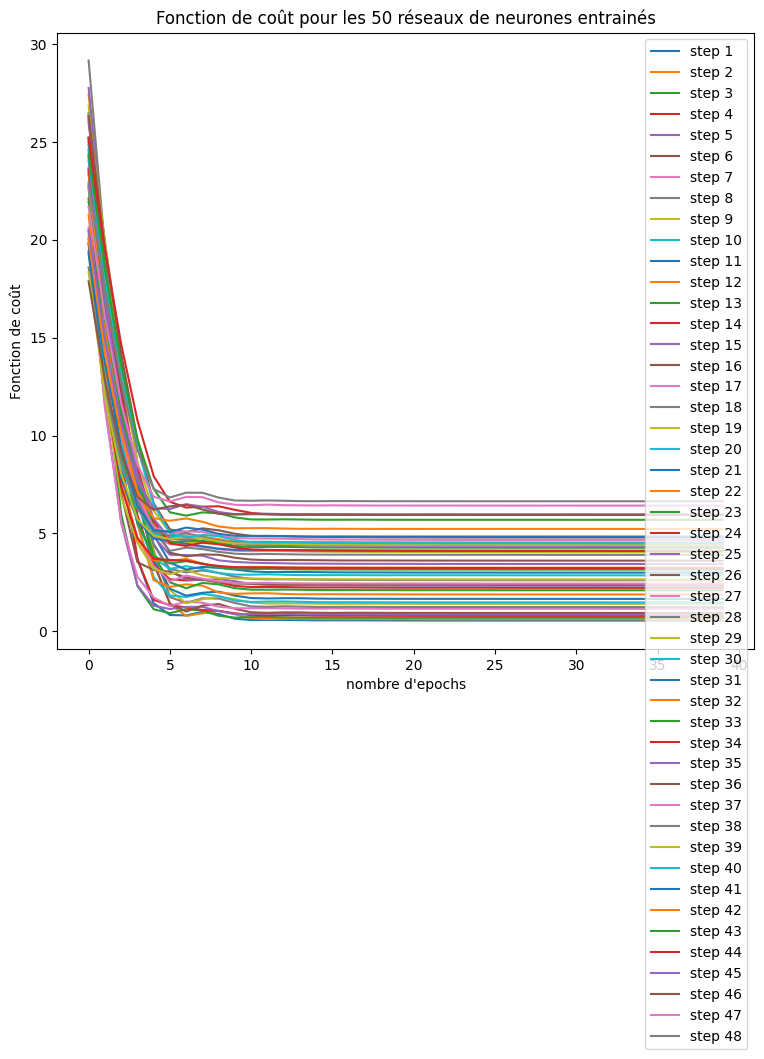

In [22]:
list_losses = pricer_ltls.intermediate_values["loss"]
list_steps = pricer_ltls.intermediate_values["step"]
list_steps = list_steps[::-1]

plt.figure(figsize=(9, 8))

for idx,loss in enumerate(list_losses):
    plt.plot(loss,label=f"step {list_steps[idx]}")

plt.xlabel("nombre d'epochs")
plt.ylabel("Fonction de coût")
plt.legend()
plt.title(f"Fonction de coût pour les {n} réseaux de neurones entrainés")

In [7]:
def plot_fit(t: int):
    """plot fitted values of basis function 

    Parameters
    ----------
    list_fun : List[basis_function.BasisFunction]
        list a basis functions.
    t : int
        timestep of the fit.
    """
    n, N = 10, 500
    batch_size = 100
    pricer = nn_ls_pricer.PricerNNLongstaffSchwarz(
        option_, asset, weights, learning_rate, batch_size, activation_function, epochs
    )
    _, _, _, _, _ = pricer.price(n, N, seed=2001)

    model = pricer.models["model"][t]
    model.eval()

    with torch.no_grad():
        x = pricer.models["underlying"][t]
        y = pricer.models["cash_flows"][t].numpy()
        fitted = torch.squeeze(model(x.unsqueeze(1))).detach().numpy()
        sorted_indices = np.argsort(x.numpy())
        x = np.array(x)[sorted_indices]
        y = y[sorted_indices]
        fitted = fitted[sorted_indices]

    # Plotting the sorted data
    plt.figure(figsize=(9, 8))
    plt.scatter(x, y, label="Actual Values")
    plt.plot(x,fitted,label="neural network fit",color="orange")    
    plt.xlabel(r"$S_{t_{n-1}}$", fontsize=15)
    plt.ylabel(r"$f(X_{\tau_n})$", fontsize=15)
    plt.title(f"Fitted values for n = {n - t}")
    plt.legend()
    plt.show()

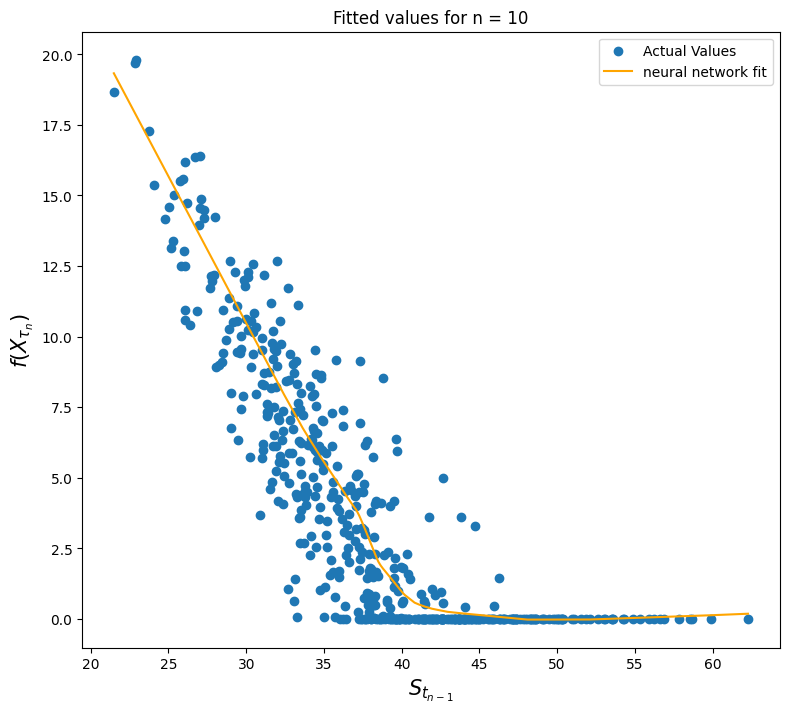

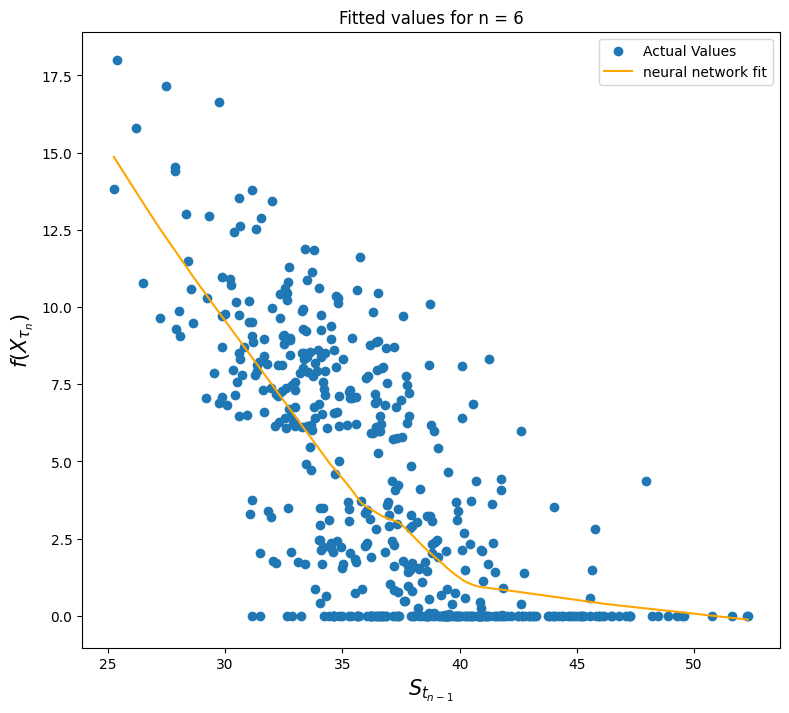

In [8]:
plot_fit(0)
plot_fit(4)

In [10]:
def call_payoff(x):
    d = x.shape[1]
    max_mat = np.zeros((x.shape[0], d))
    for i in range(d):
        max_mat[:, i] = np.maximum(x[:, i] - strike, 0)
    return np.max(max_mat, axis=1)

In [11]:
tirage = 20
n = 10
strike = 100


o = option_main_class.Option(3, 100, 0.05, call_payoff)
asset1 = [bs.BlackScholes(110, 0.05, 0.2, 0.10) for _ in range(2)]
asset2 = [bs.BlackScholes(110, 0.05, 0.2, 0.10) for _ in range(20)]
pricer1 = nn_ls_pricer.PricerNNLongstaffSchwarz(
    o, asset1, weights, learning_rate, batch_size, activation_function, epochs
)
pricer2 = nn_ls_pricer.PricerNNLongstaffSchwarz(
    o, asset2, weights, learning_rate, batch_size, activation_function, epochs
)

list_number_simulations = [N for N in range(10, 100000, 20000)]
list_max_call_price1 = np.zeros((tirage, 5))
list_max_call_price2 = np.zeros((tirage, 5))
list_time = np.zeros((tirage, 5))
list_CI_down = []
List_CI_up = []

for idx, n_simulation in tqdm(enumerate(range(10, 100000, 20000))):
    ci_down_tmp = 0
    ci_up_tmp = 0
    for m in range(tirage):
        price1, CI_up, CI_down, t, _ = pricer1.price(n, n_simulation)
        price2, _, _, _, _ = pricer2.price(n, n_simulation)
        list_max_call_price1[m, idx] = price1
        list_max_call_price2[m, idx] = price2
        list_time[m, idx] = t
        ci_down_tmp += CI_down
        ci_up_tmp += CI_up
    list_CI_down.append(ci_down_tmp / tirage)
    List_CI_up.append(ci_up_tmp / tirage)

1it [00:40, 40.20s/it]


KeyboardInterrupt: 

In [6]:
list_number_simulations = [N for N in range(10, 100000, 20000)]

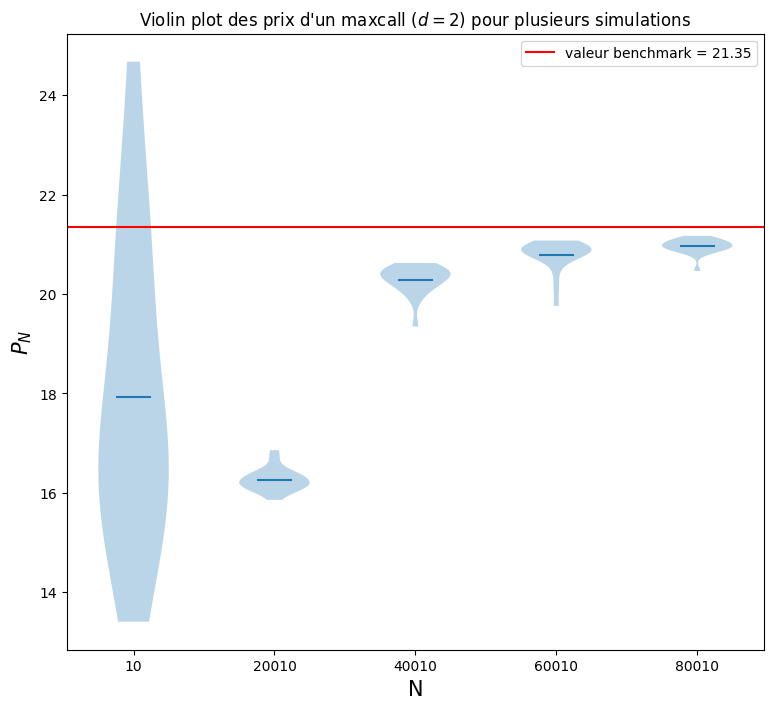

In [7]:
benchmark = 21.349
helper_plots.violin_plot(
    list_max_call_price1,
    list_number_simulations,
    benchmark,
    "Violin plot des prix d'un maxcall ($d=2$) pour plusieurs simulations",
)

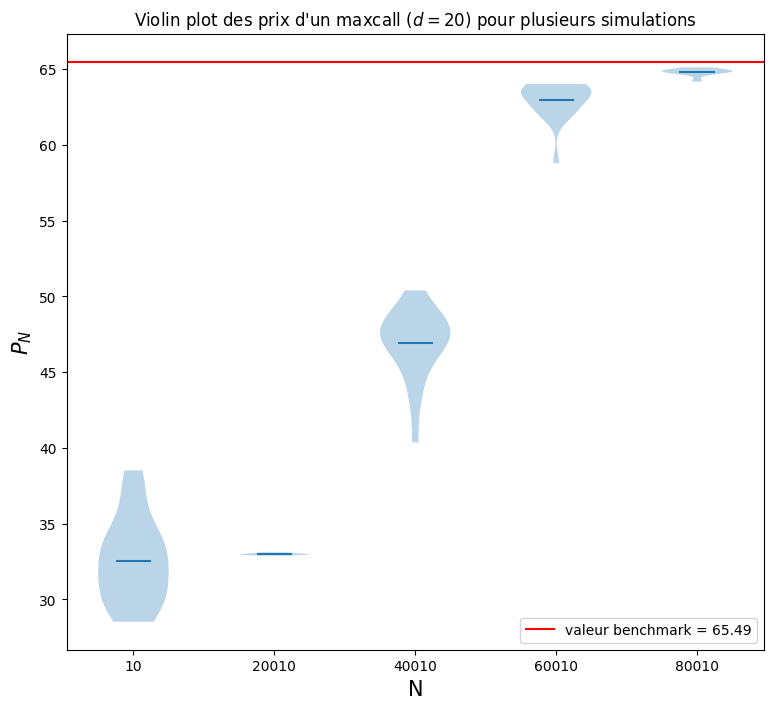

In [8]:
benchmark = 65.494
helper_plots.violin_plot(
    list_max_call_price2,
    list_number_simulations,
    benchmark,
    "Violin plot des prix d'un maxcall ($d=20$) pour plusieurs simulations",
)